In [45]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.fftpack import fft

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import time
import threading

In [60]:
keep_running = True
output = widgets.Output()

def on_button_click(b):
    global keep_running
    global output
    global stream
    global audio
    global plt
    global fig
    keep_running = False
    
    # Clear the current output and then display the new message
    clear_output(wait=True)
    with output:
        print(f"Keep running: {keep_running} {stream}")
        if not (stream is None):
            print(f"Closing audio")
            stream.stop_stream()
            stream.close()
            audio.terminate()
            plt.close(fig)

button = widgets.Button(description="Stop")
button.on_click(on_button_click)
with output:
    print(f"Keep running: {keep_running}")
display(button, output)

Button(description='Stop', style=ButtonStyle())

Output()

In [4]:
def open_stream(audio, format=pyaudio.paInt16, channels=1, rate=44100, chunk=1024):
    # Open stream
    stream = audio.open(format=format,
                    channels=channels,
                    rate=rate,
                    input=True,
                    frames_per_buffer=chunk)
    return stream

In [91]:
def analyse_spectrum(stream, chunk, rate):
    global plt
    global fig
    plt.ion()
    fig, ax = plt.subplots()

    # Labeling
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Binned Magnitudes of Frequencies')

    # Bin the magnitudes
    num_bins = 30
    min_frequency = 100
    max_frequency = 15000

    # Generate exponential bins from min_frequency to max_frequency
    bins = np.logspace(np.log10(min_frequency), np.log10(max_frequency), num_bins + 1)
    bin_midpoints = np.sqrt(bins[:-1] * bins[1:])  # Midpoints for x-axis labels
    x = np.arange(num_bins)  # x positions for the bars

    # Initialize bars
    bars = ax.bar(x, np.zeros(num_bins), align='center', edgecolor='black')
    ax.set_xticks(x[::5])  # Set ticks at every 5th position
    ax.set_xticklabels(["{:.0f} Hz".format(freq) for freq in bin_midpoints[::5]])

    # Start the stream
    stream.start_stream()

    while keep_running:
        data = stream.read(chunk, exception_on_overflow=False)

        # Extract left channel data
        frames = np.frombuffer(data, dtype=np.int16)[0::2]

        # Apply FFT and get frequency magnitudes
        fft_result = np.fft.fft(frames)
        magnitudes = np.abs(fft_result)

        # Compute indices for binning
        frequencies = np.fft.fftfreq(len(fft_result), d=1.0/rate)
        indices = np.digitize(frequencies, bins)
        binned_magnitudes = np.zeros(num_bins)

        for i in range(1, len(bins)):
            bin_indices = indices == i
            if np.any(bin_indices):  # Only calculate mean if there are elements in the bin
                binned_magnitudes[i-1] = np.mean(magnitudes[bin_indices])

        # Update the bars with actual magnitudes
        for bar, height in zip(bars, binned_magnitudes):
            bar.set_height(height)

        # Update the plot limits and view
        ax.relim()
        ax.autoscale_view()

        # Update the figure canvas
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Introduce a short pause
        plt.pause(0.01)

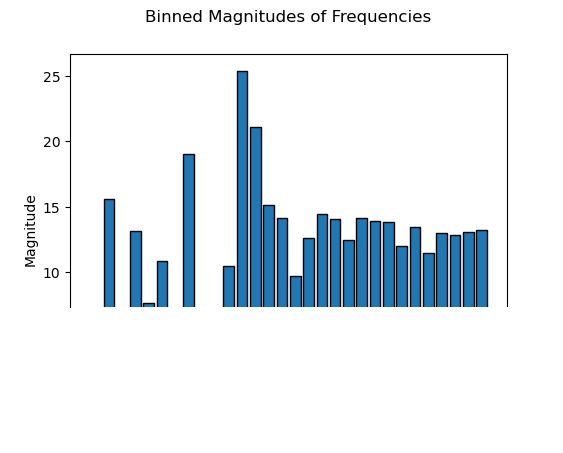

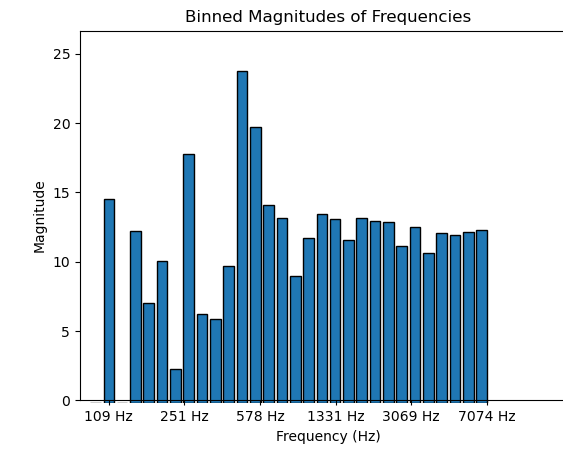

In [92]:
keep_running = True
audio = pyaudio.PyAudio()
stream = open_stream(audio, channels=2)
thread = threading.Thread(target=analyse_spectrum, args=(stream, 1024, 44100))
thread.start()

In [63]:
audio = pyaudio.PyAudio()
stream = open_stream(audio, channels=2)

# Start the stream
stream.start_stream()

data = stream.read(1024, exception_on_overflow=False)

# Extract left channel data
frames = np.frombuffer(data, dtype=np.int16)[0::2]

# Apply FFT and get frequency magnitudes
fft_result = np.fft.fft(frames)
frequencies = np.fft.fftfreq(len(fft_result), d=1.0/44100)
magnitudes = np.abs(fft_result)

# Bin the magnitudes
num_bins = 30
min_frequency = 100
max_frequency = 15000

# Generate exponential bins from min_frequency to max_frequency
bins = np.logspace(np.log10(min_frequency), np.log10(max_frequency), num_bins + 1)
indices = np.digitize(frequencies, bins)
binned_magnitudes = np.zeros(num_bins)

for i in range(1, len(bins)):
    bin_indices = indices == i
    if np.any(bin_indices):  # Only calculate mean if there are elements in the bin
        binned_magnitudes[i-1] = np.mean(magnitudes[bin_indices])

stream.stop_stream()
stream.close()
audio.terminate()

In [27]:
print(binned_magnitudes)

[   0.         3704.81951294    0.         4064.51955024 2812.69423619
 3695.26877286 2919.93257552 5314.49716429 4253.48257725 4250.97988835
 3806.24760974 4216.69474043 5678.67795377 4231.30870041 4269.41748266
 3638.9066646  5439.26904642 5926.84165654 4470.24122247 5653.71881324
 5164.86838718 5555.58793545 6353.99984345 7803.97625327 7494.84510288
 8290.8245332  1838.38010638  410.15990583  209.90486104  126.64526078]


In [28]:
print(bins)

[  100.           118.1779291    139.66022925   165.0475667
   195.04979635   230.50581003   272.40699274   321.92494274
   380.44423057   449.60111305   531.32928459   627.91394521
   742.05569695   876.94605539  1036.35668755  1224.74487139
  1447.37812572  1710.48149516  2021.41160854  2388.86237747
  2823.10808664  3336.29067293  3942.75922588  4659.47120237
  5506.46657377  6507.42816323  7690.3438407   9088.28909128
 10740.3518383  12692.7253801  15000.        ]


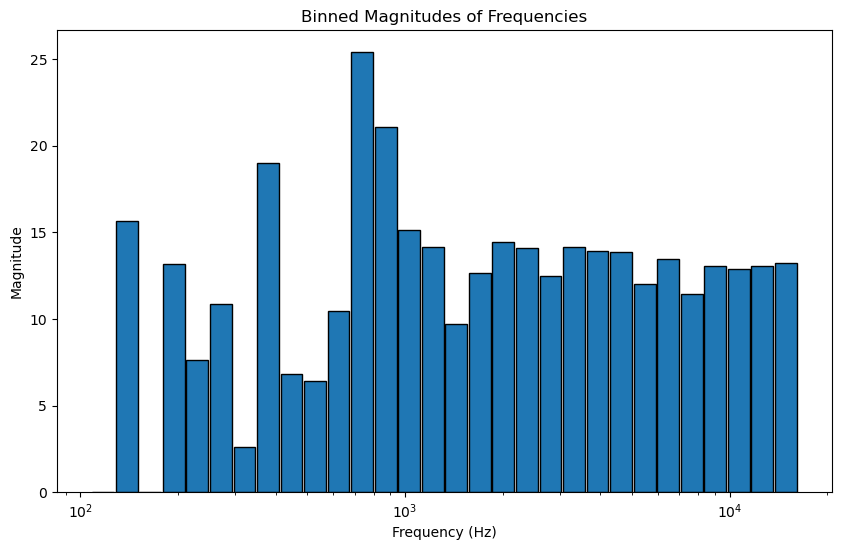

In [64]:
# Calculate the geometric mean of the bin edges for x-axis labels
bin_midpoints = np.sqrt(bins[:-1] * bins[1:])

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(bin_midpoints, binned_magnitudes, width=np.diff(bins), align='edge', edgecolor='black')

# Set the scale of the x-axis to logarithmic
plt.xscale('log')

# Labeling
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Binned Magnitudes of Frequencies')

# Show the plot
plt.show()

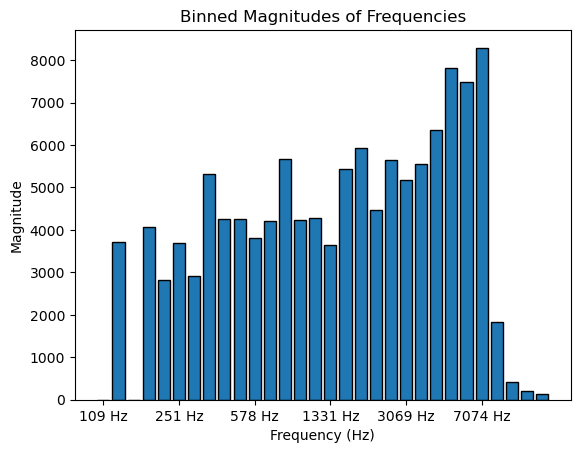

In [48]:
plt.ion()
fig, ax = plt.subplots()

# Labeling
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Binned Magnitudes of Frequencies')

# Number of bins
num_bins = len(binned_magnitudes)

# Create evenly spaced x values for the bars
x = np.arange(num_bins)

# Initialize bars with zeros
bars = ax.bar(x, np.zeros(num_bins), align='center', edgecolor='black')

# Set custom x-axis tick labels, displaying every 5th label
ax.set_xticks(x[::5])  # Set ticks at every 5th position
ax.set_xticklabels(["{:.0f} Hz".format(freq) for freq in bin_midpoints[::5]])

# Update the bars with actual magnitudes
for bar, height in zip(bars, binned_magnitudes):
    bar.set_height(height)

# Update the plot limits and view
ax.relim()
ax.autoscale_view()

# Update the figure canvas
fig.canvas.draw()
fig.canvas.flush_events()

In [36]:
plt.close(fig)

In [42]:
print(bin_midpoints)

[  108.70967257   128.47083977   151.82417793   179.42266934
   212.03799496   250.58211133   296.13274986   349.96355116
   413.57967735   488.75989785   577.60632553   682.60319384
   806.68631842   953.32518541  1126.61996166  1331.41613947
  1573.44002127  1859.4588327   2197.46994087  2596.92446862
  3068.9915572   3626.87066641  4286.16064455  5065.29588744
  5986.06178235  7074.20384877  8360.14760848  9879.84931305
 11675.80131593 13798.2202005 ]


In [49]:
len(fft_result)

1024